In [1]:
# Import Packages
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt 
from scipy.optimize import minimize

##### Gathering Stock Data from Yahoo Finance

In [2]:
#Download Stock Data 
tickers = ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'NVDA', 'KO', 'JNJ', 'PG', 'PEP', 'XOM']

start_date = dt.datetime.today()-dt.timedelta(days=5*365) #data from last 5 years
end_date = dt.datetime.today()

stock = yf.download(tickers, start = start_date, end =end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


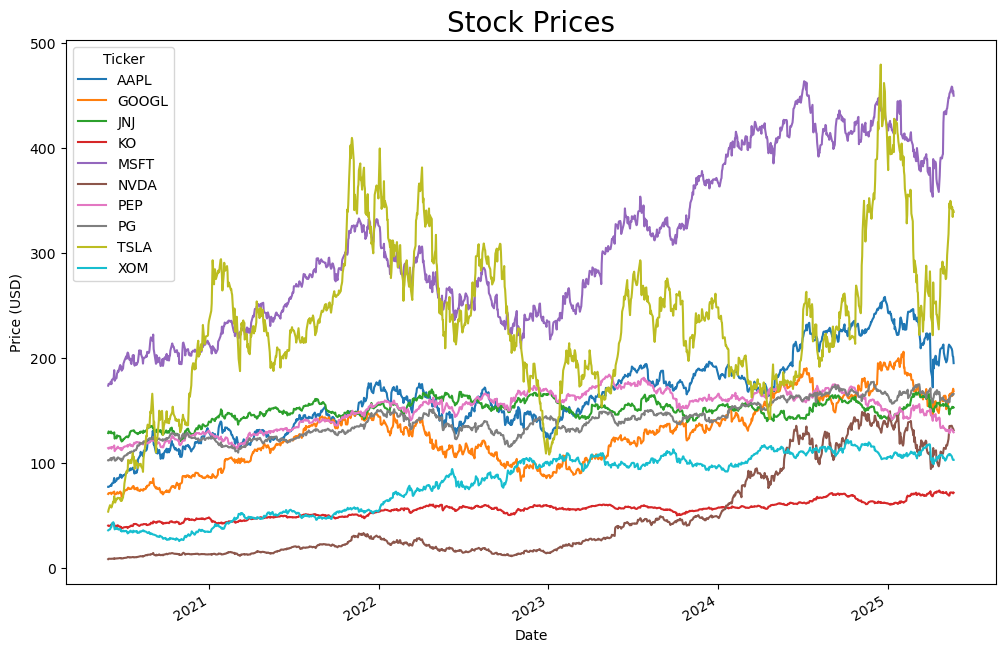

In [3]:
#Plot stock (close) prices together
stock['Close'].plot(figsize = (12,8))
plt.title(f'Stock Prices', size = 20)
plt.ylabel('Price (USD)')
plt.show()

###### Compute Daily Log returns of stocks

In [4]:
# Compute daily log returns dropping NaN
daily_log_returns = np.log(stock['Close']/ stock['Close'].shift(1)).dropna()
print(daily_log_returns.head())

Ticker          AAPL     GOOGL       JNJ        KO      MSFT      NVDA  \
Date                                                                     
2020-05-29 -0.000974  0.010716  0.012039 -0.008745  0.010147  0.044759   
2020-06-01  0.012223  0.000941 -0.010543  0.006619 -0.002294 -0.007833   
2020-06-02  0.004619  0.005172  0.007176 -0.001917  0.011312  0.002155   
2020-06-03  0.005490 -0.002124  0.002695  0.021098  0.002431 -0.006337   
2020-06-04 -0.008650 -0.017487 -0.013000  0.000417 -0.013251  0.000114   

Ticker           PEP        PG      TSLA       XOM  
Date                                                
2020-05-29 -0.005610 -0.001207  0.035584  0.009502  
2020-06-01  0.010887  0.011408  0.072850  0.017657  
2020-06-02 -0.002711  0.006885 -0.018588  0.022012  
2020-06-03  0.001432  0.003973  0.001587  0.039985  
2020-06-04 -0.009353 -0.021145 -0.021267 -0.002847  


#### Investigate if the log returns of stocks choosen are normally distributed.

In [5]:
#Normality Test Functions: Shaprio-Wilk Test, Anderson-Darling Test, Jarque-Bera Test
from scipy.stats import shapiro, anderson, jarque_bera

def normality_tests(series):
    # Drop missing values
    series = series.dropna()
    
    # Shapiro-Wilk Test
    sw_stat, sw_p = shapiro(series)
    
    # Anderson-Darling Test
    ad_result = anderson(series)
    ad_stat = ad_result.statistic
    ad_crit_val_5 = ad_result.critical_values[2] #critical value at 5% significance level
    ad_pass = ad_stat < ad_crit_val_5  # Sample Passes the test if stat < critical value at 5%
    
    # Jarque-Bera Test
    jb_stat, jb_p = jarque_bera(series)
    
    # Return dictionary of results
    return {
        "Shapiro-Wilk (p)": round(sw_p, 4),
        "Jarque-Bera (p)": round(jb_p, 4),
        "Anderson-Darling (stat)": round(ad_stat, 4),
        "AD < CV(5%)": ad_pass
    }


In [6]:
# Run Normality Tests
results = {ticker: normality_tests(daily_log_returns[ticker]) for ticker in tickers}
normality_df = pd.DataFrame(results).T
print("Full Data Normality Test Results:")
print(normality_df)

Full Data Normality Test Results:
      Shapiro-Wilk (p) Jarque-Bera (p) Anderson-Darling (stat) AD < CV(5%)
AAPL               0.0             0.0                  9.5249       False
MSFT               0.0             0.0                  6.5097       False
GOOGL              0.0             0.0                  8.0938       False
TSLA               0.0             0.0                   6.259       False
NVDA               0.0             0.0                  4.6643       False
KO                 0.0             0.0                   9.234       False
JNJ                0.0             0.0                  6.9214       False
PG                 0.0             0.0                  7.8663       False
PEP                0.0             0.0                  7.5105       False
XOM                0.0             0.0                  3.8654       False


This confirms that none of the stock return distributions resemble a normal distribution over the full time period.

In [7]:
import statsmodels.api as sm
sns.set(style='whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


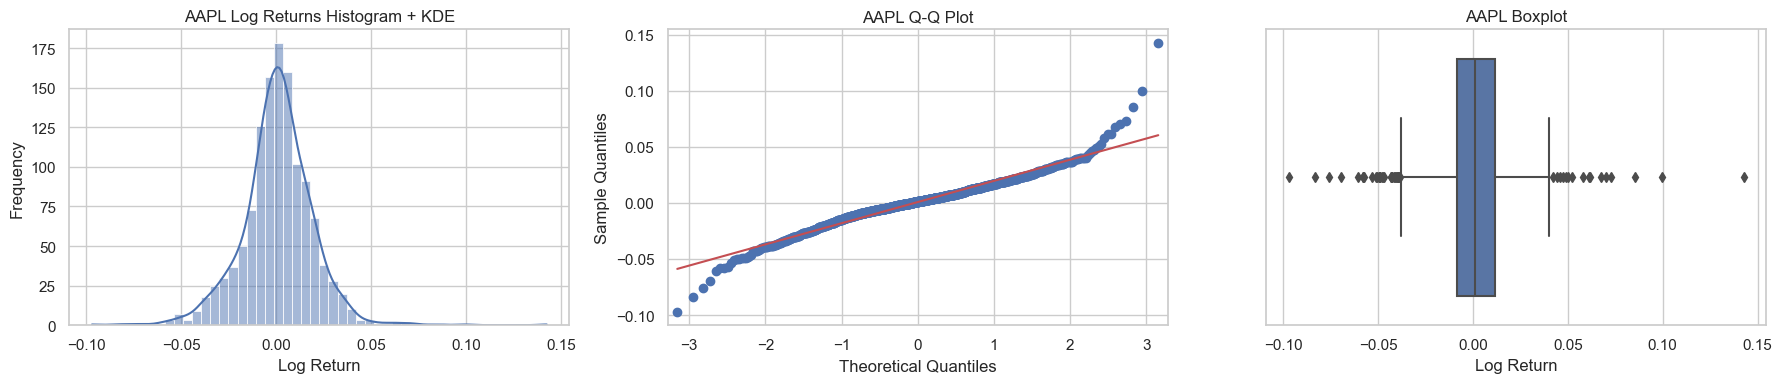

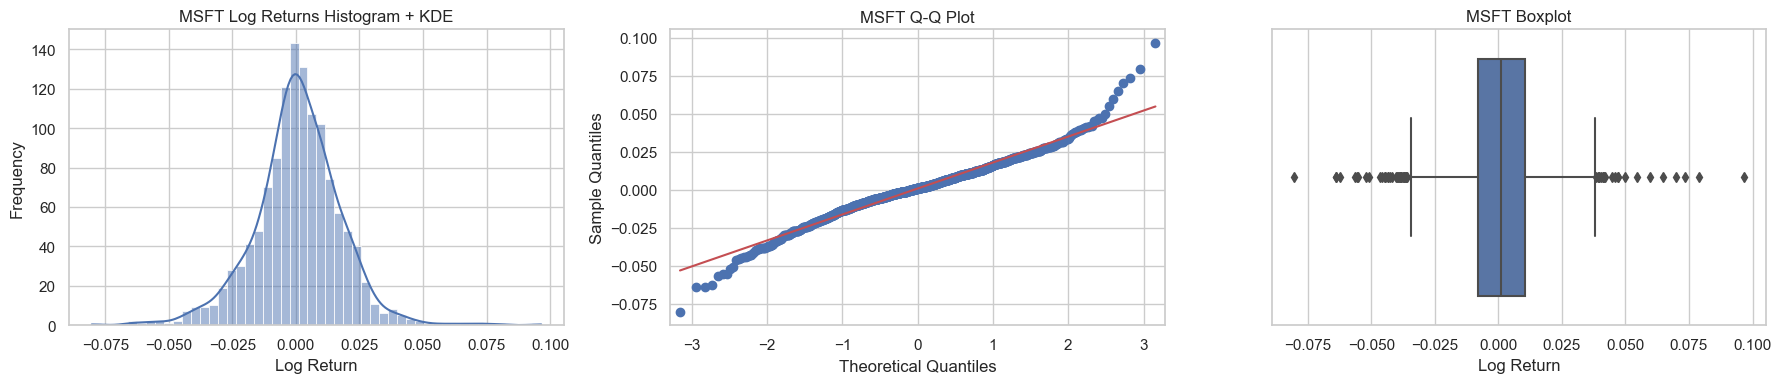

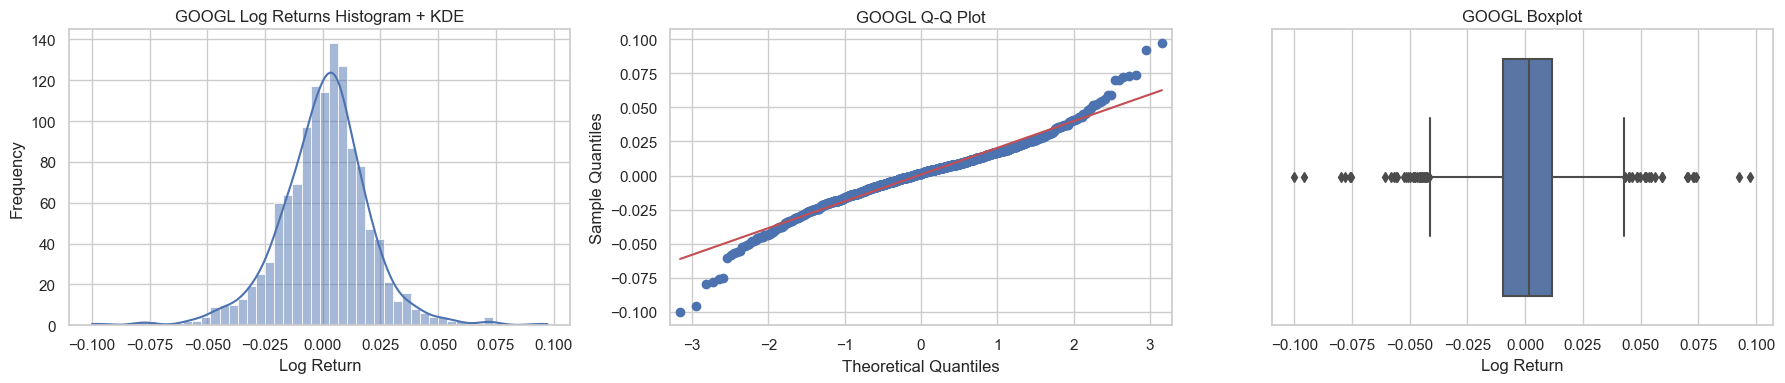

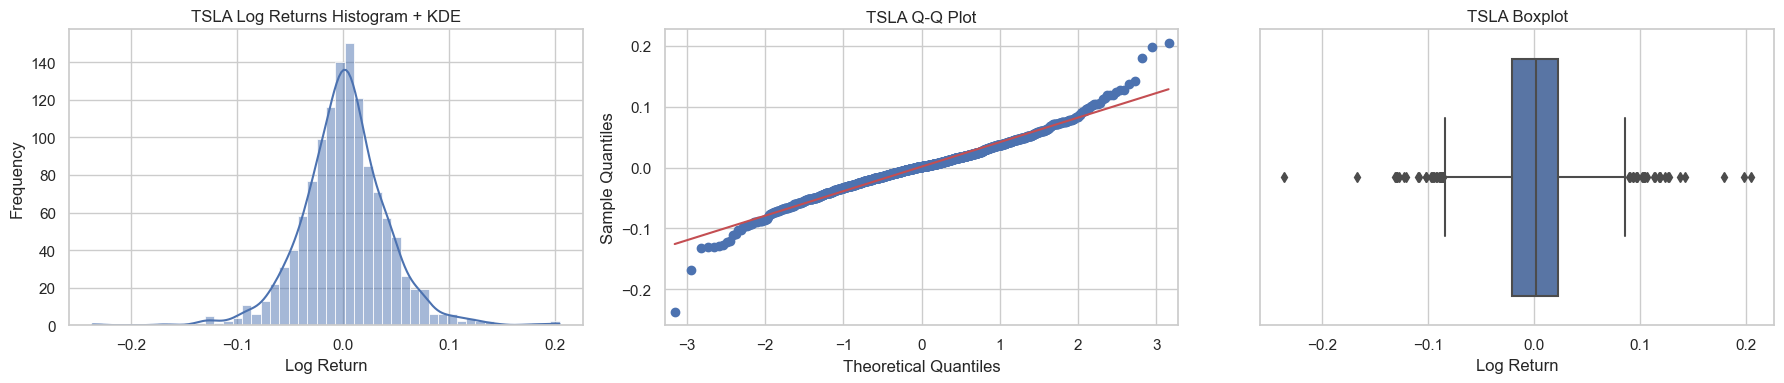

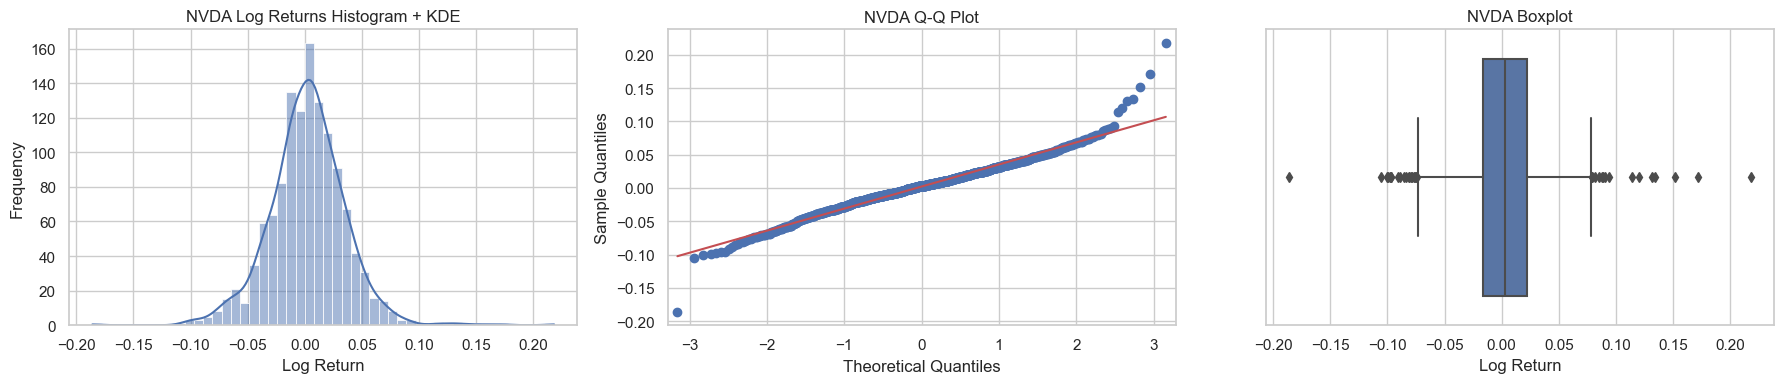

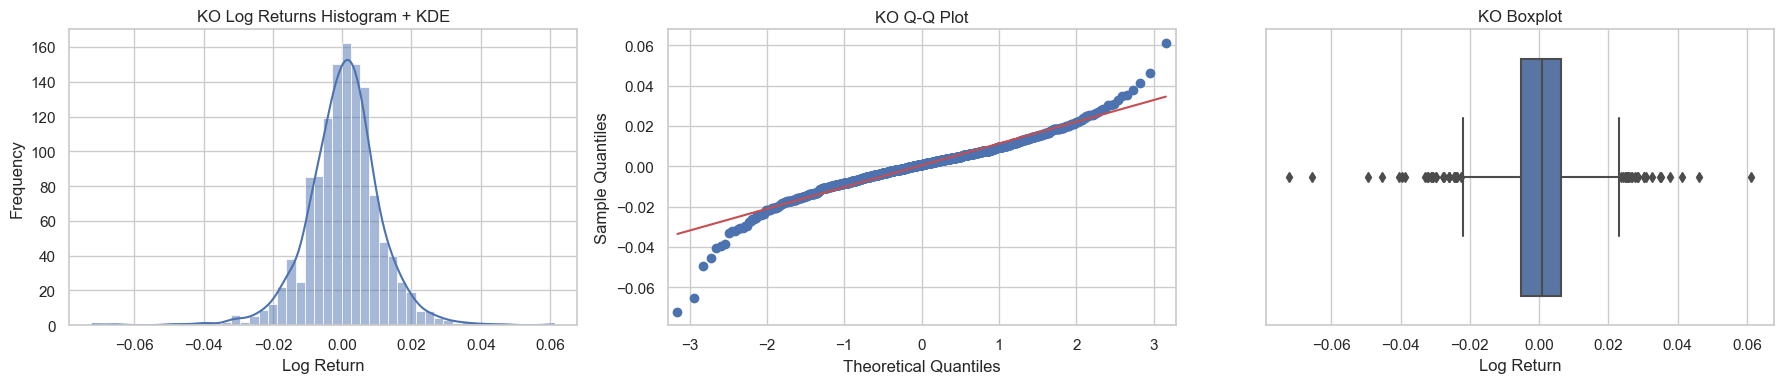

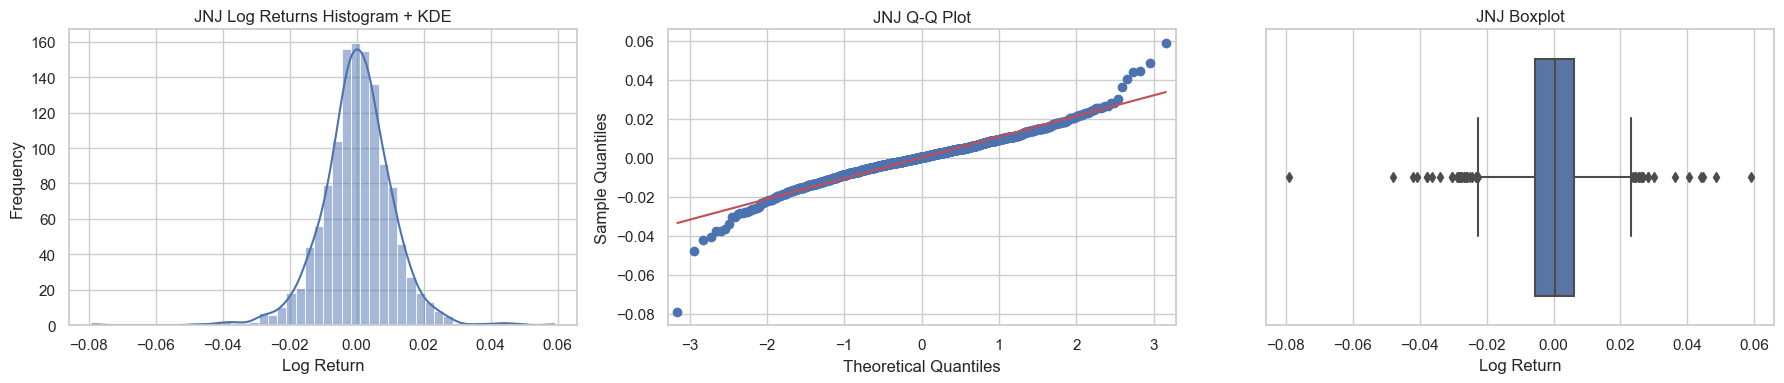

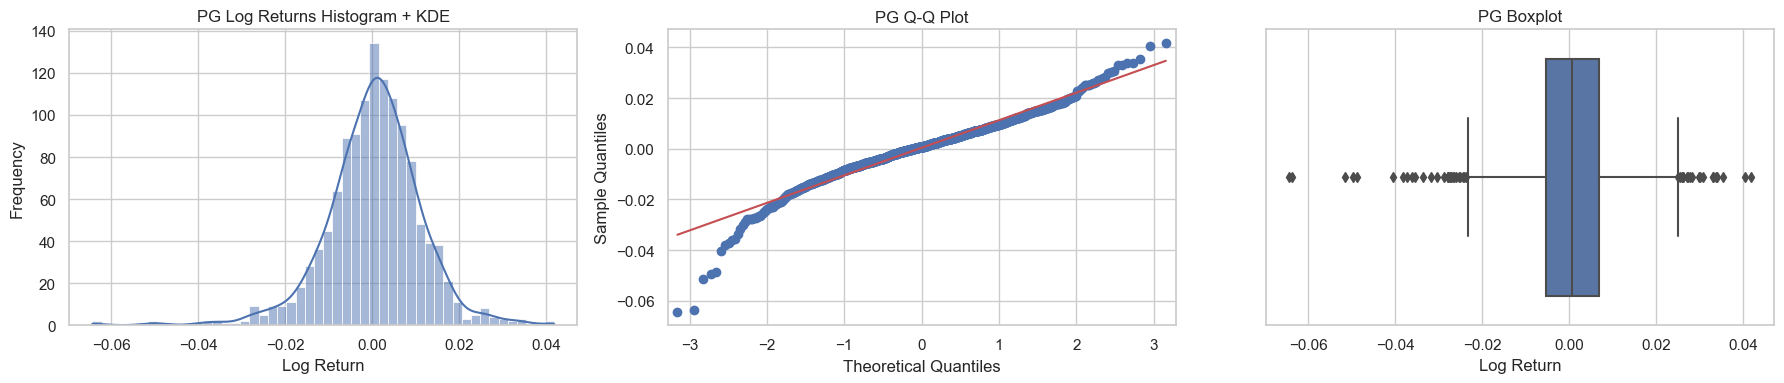

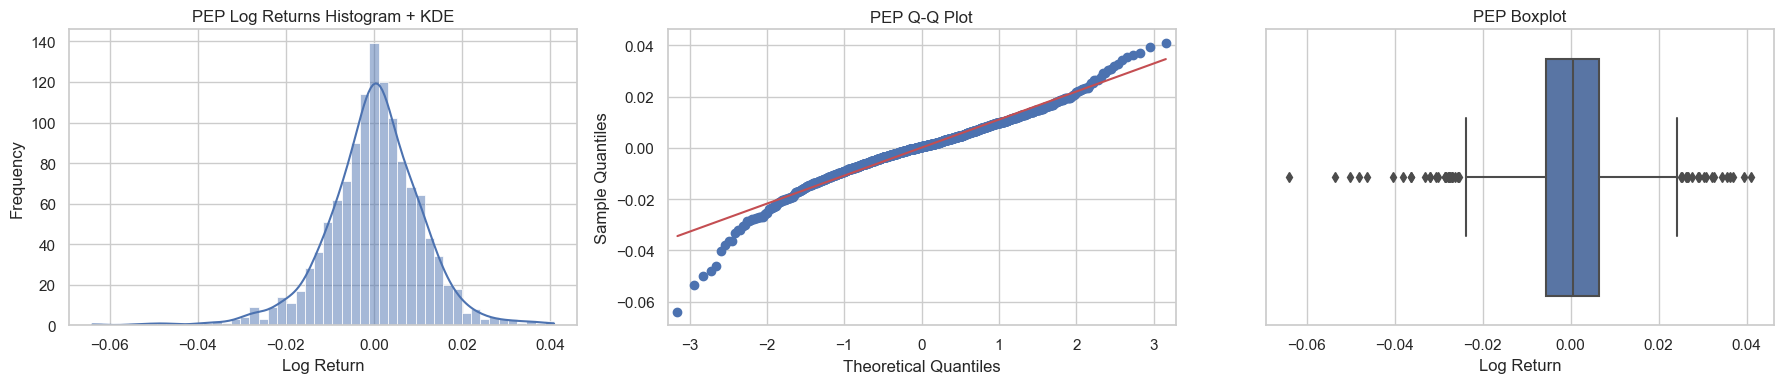

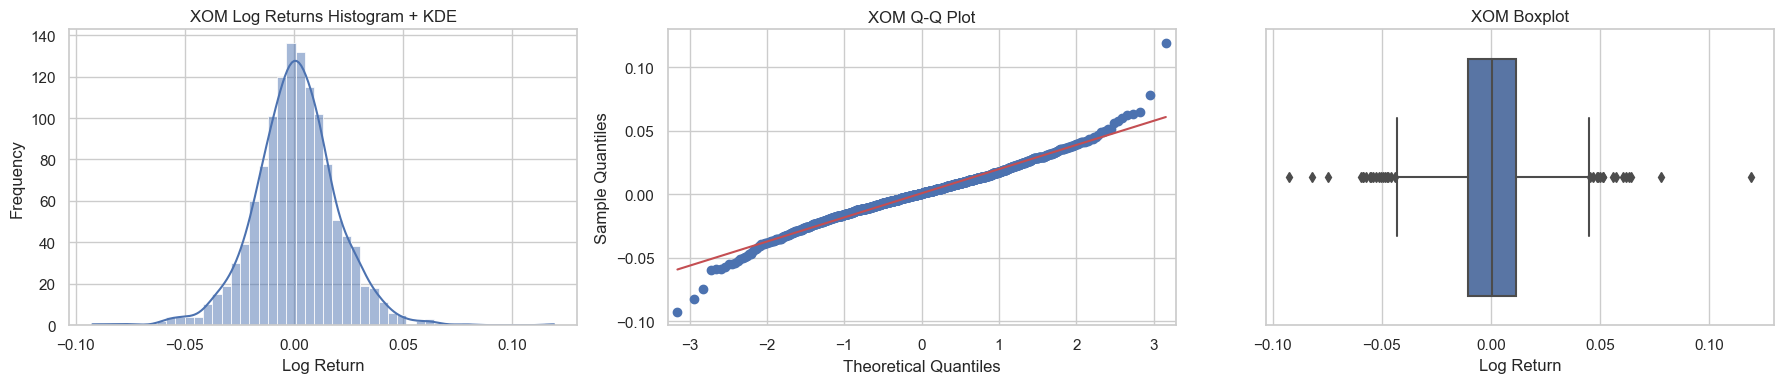

In [8]:
# Visual Diagnostics for Each Stock
for stock in tickers:
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # 1. Histogram with KDE
    sns.histplot(daily_log_returns[stock], bins=50, kde=True, ax=axs[0])
    axs[0].set_title(f"{stock} Log Returns Histogram + KDE")
    axs[0].set_xlabel("Log Return")
    axs[0].set_ylabel("Frequency")

    # 2. Q-Q Plot
    sm.qqplot(daily_log_returns[stock], line='s', ax=axs[1])
    axs[1].set_title(f"{stock} Q-Q Plot")

    # 3. Boxplot
    sns.boxplot(x=daily_log_returns[stock], ax=axs[2])
    axs[2].set_title(f"{stock} Boxplot")
    axs[2].set_xlabel("Log Return")

    plt.tight_layout()
    plt.show()

Visual diagnostics also confirm that none of the stock return distributions resemble a normal distribution over the full time period.

#### Now we will test if there are period of times when the log-returns of stocks have evidence of normal distribution.
For that we will use the rolling Anderson-Darling test.

In [10]:
# rolling window size (126 days ≈ 6 months)
window_size = 126
# Create a dictionary to store % of windows passing normality
rolling_ad_pass_rate = {}

# Loop through each stock's column in daily_log_returns DataFrame
for stock in daily_log_returns.columns:
    series = daily_log_returns[stock].dropna()
    rolling_results = []

    for i in range(len(series) - window_size):
        window = series.iloc[i:i + window_size]
        ad_result = anderson(window)
        passed = ad_result.statistic < ad_result.critical_values[2]  # 5% level
        rolling_results.append(passed)

    # Store percentage of windows that passed
    rolling_ad_pass_rate[stock] = round(np.mean(rolling_results) * 100, 2)

# Convert to DataFrame for display
rolling_ad_df = pd.DataFrame.from_dict(rolling_ad_pass_rate, orient='index', columns=['% Windows Passing Normality'])

# Show results
print(rolling_ad_df.sort_values(by='% Windows Passing Normality', ascending=False))


       % Windows Passing Normality
XOM                          80.32
AAPL                         61.44
NVDA                         59.84
MSFT                         58.78
TSLA                         44.68
KO                           44.41
PEP                          42.38
PG                           42.29
JNJ                          40.60
GOOGL                        33.60


XOM, AAPL, NVDA, and MSFT exhibit relatively consistent normality in their log returns, passing the Anderson-Darling test in over 55% of 6-month periods. In contrast, GOOGL and several consumer staples (KO, PG, PEP, JNJ) pass less than 45% of the time, indicating frequent deviations from normality.

#### Now we will test if removing extremal return data creates a distribution with evidence of being normal.
We will test if trimming the top and bottom 1% of log returns results in distributions that pass normality tests more often.

##### Test normality after trimming extremes

In [13]:
# Function to test normality after trimming extremes (1% from each end)
def test_normality_after_trimming(series, trim_percent=0.01):
    series = series.dropna()
    
    # Trim top and bottom trim_percent
    lower = series.quantile(trim_percent)
    upper = series.quantile(1 - trim_percent)
    trimmed = series[(series >= lower) & (series <= upper)]

    # Apply normality tests
    sw_t_p = shapiro(trimmed)[1]
    jb_t_p = jarque_bera(trimmed)[1]
    ad_t_result = anderson(trimmed)
    ad_t_pass = ad_t_result.statistic < ad_t_result.critical_values[2]  # 5% level

    return {
        'SW p (trimmed)': round(sw_t_p, 4),
        'JB p (trimmed)': round(jb_t_p, 4),
        'AD pass (trimmed)': ad_t_pass
    }

# Apply to all stocks in daily_log_returns
after_trim_results = {}

for stock in daily_log_returns.columns:
    after_trim_results[stock] = test_normality_after_trimming(daily_log_returns[stock])

# Convert to DataFrame
after_trim_normality_df = pd.DataFrame(after_trim_results).T

print("Trimmed (1%) Data Normality Test Results:")
print(after_trim_normality_df)


Trimmed (1%) Data Normality Test Results:
      SW p (trimmed) JB p (trimmed) AD pass (trimmed)
AAPL             0.0         0.0009             False
GOOGL         0.0001         0.0022             False
JNJ           0.0052         0.0563             False
KO            0.0003         0.0045             False
MSFT          0.0001         0.0087             False
NVDA           0.004         0.2335             False
PEP              0.0         0.0001             False
PG            0.0001         0.0002             False
TSLA          0.0025         0.2403             False
XOM           0.0499         0.9565              True


After trimming the top and bottom 1% of daily log returns, most stocks still fail normality tests, suggesting that extreme values are not the sole cause of non-normal behavior. Only XOM shows clear improvement, passing all tests and exhibiting near-normal returns after trimming.

Visual Comparison of Normality (Before vs After Trimming)

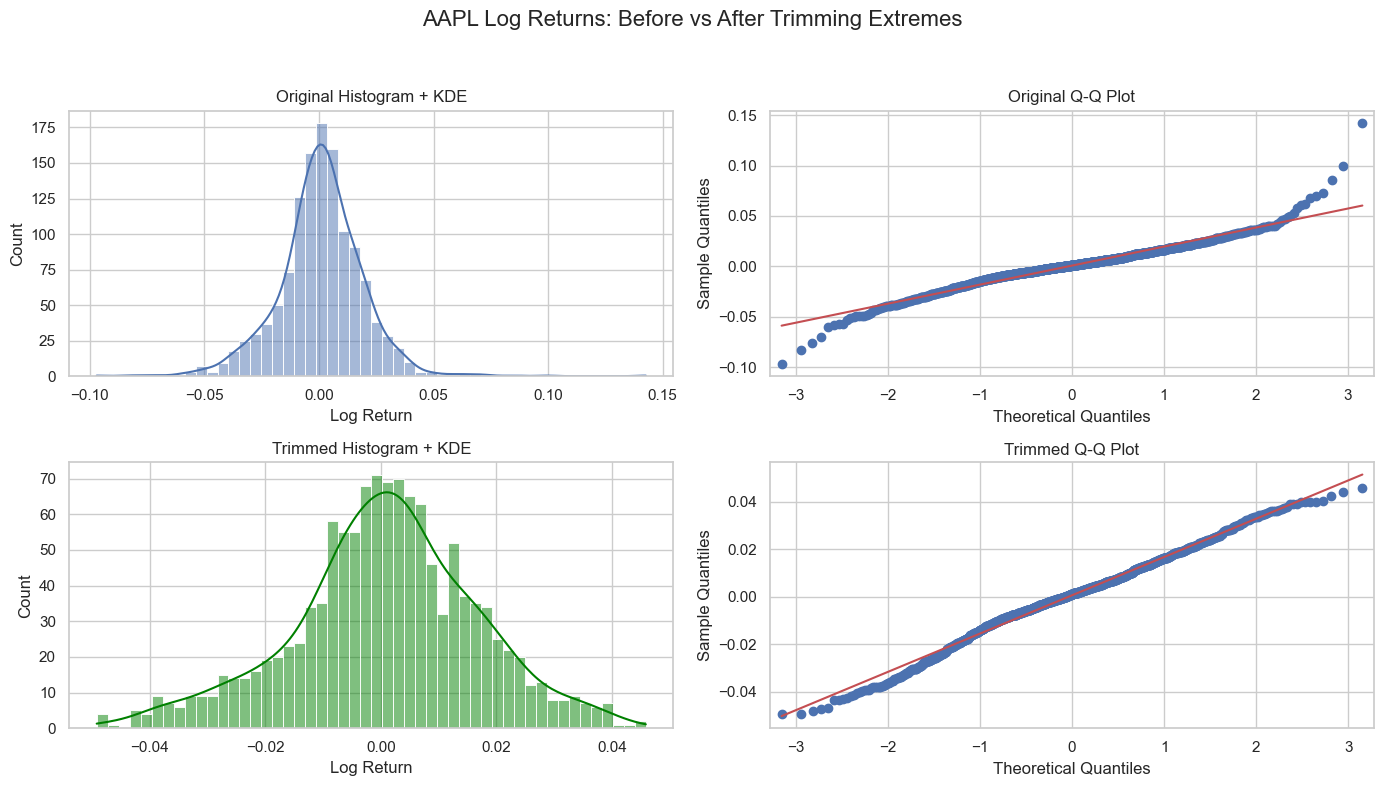

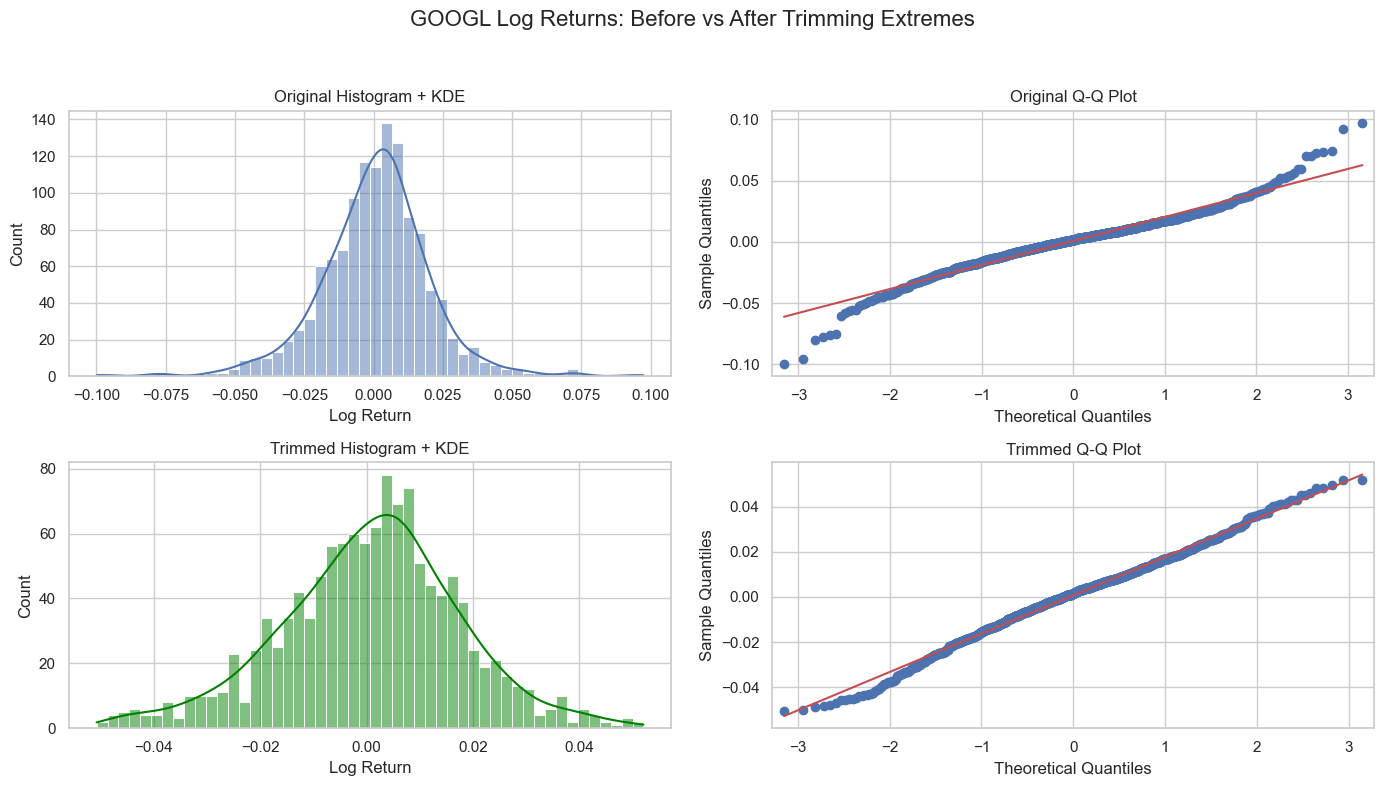

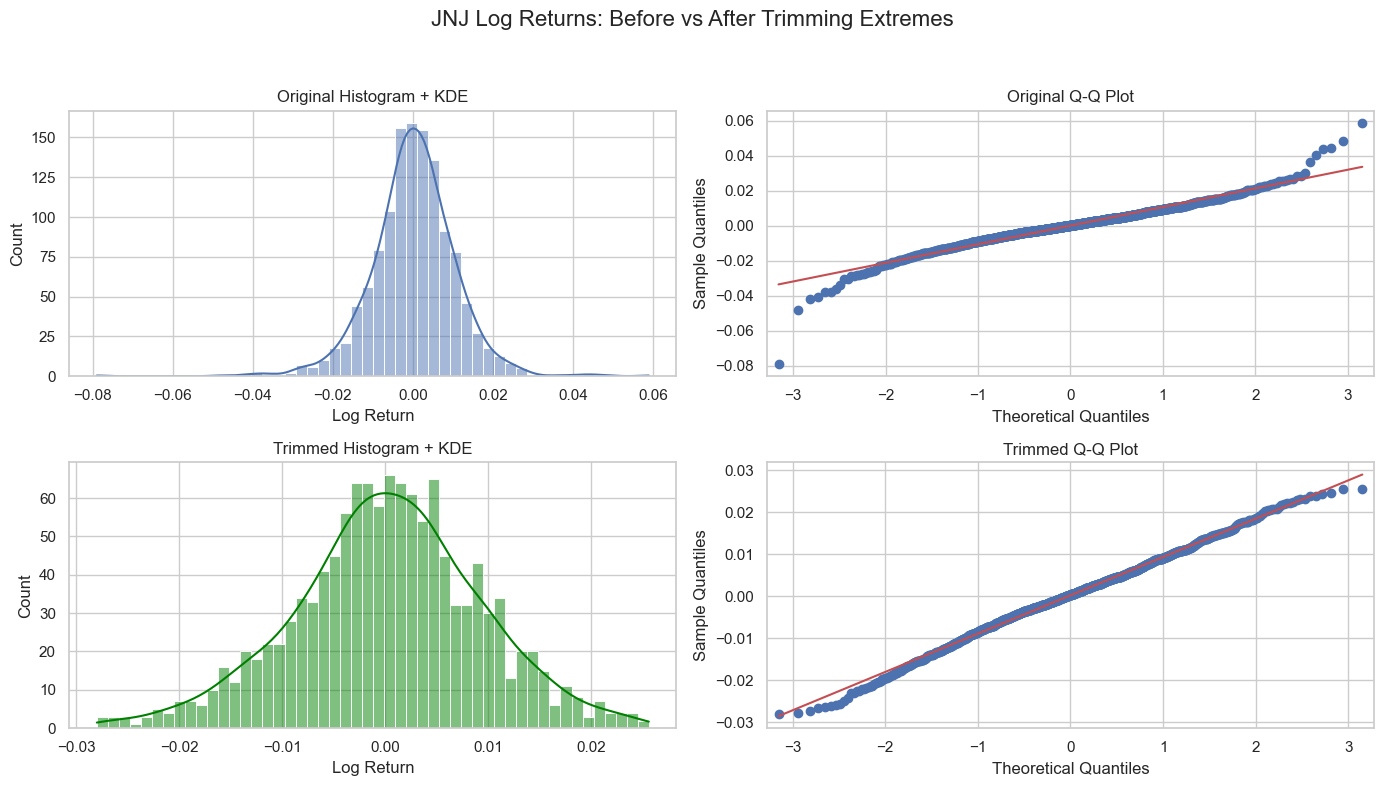

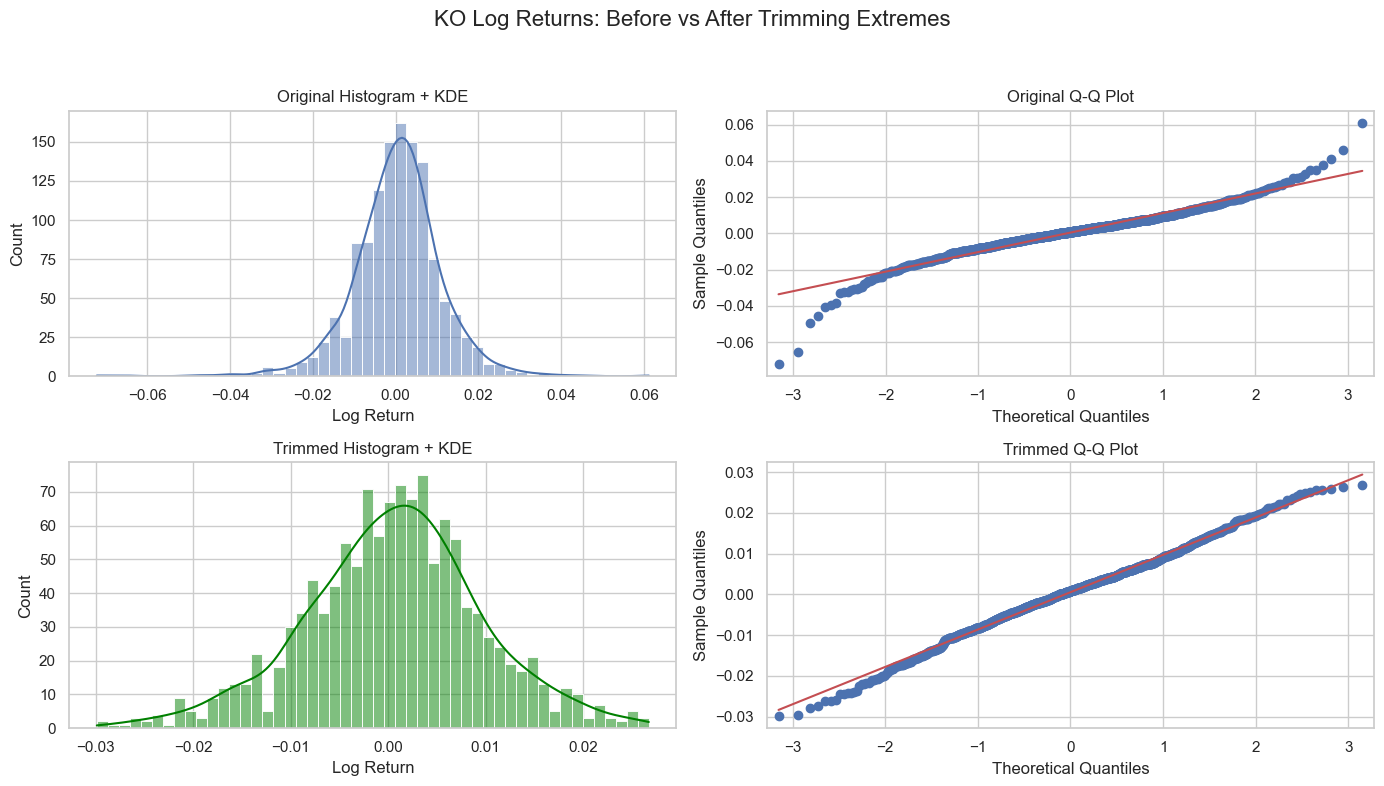

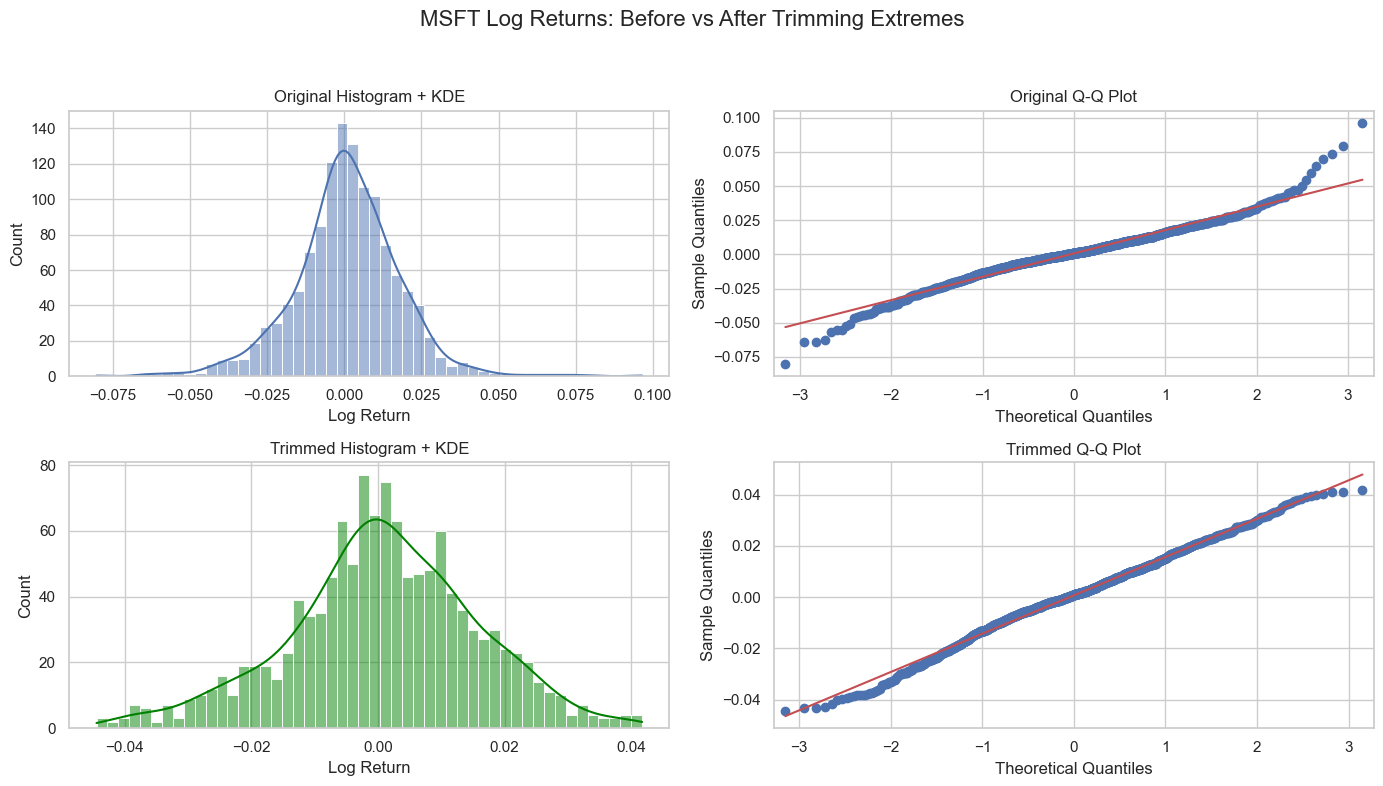

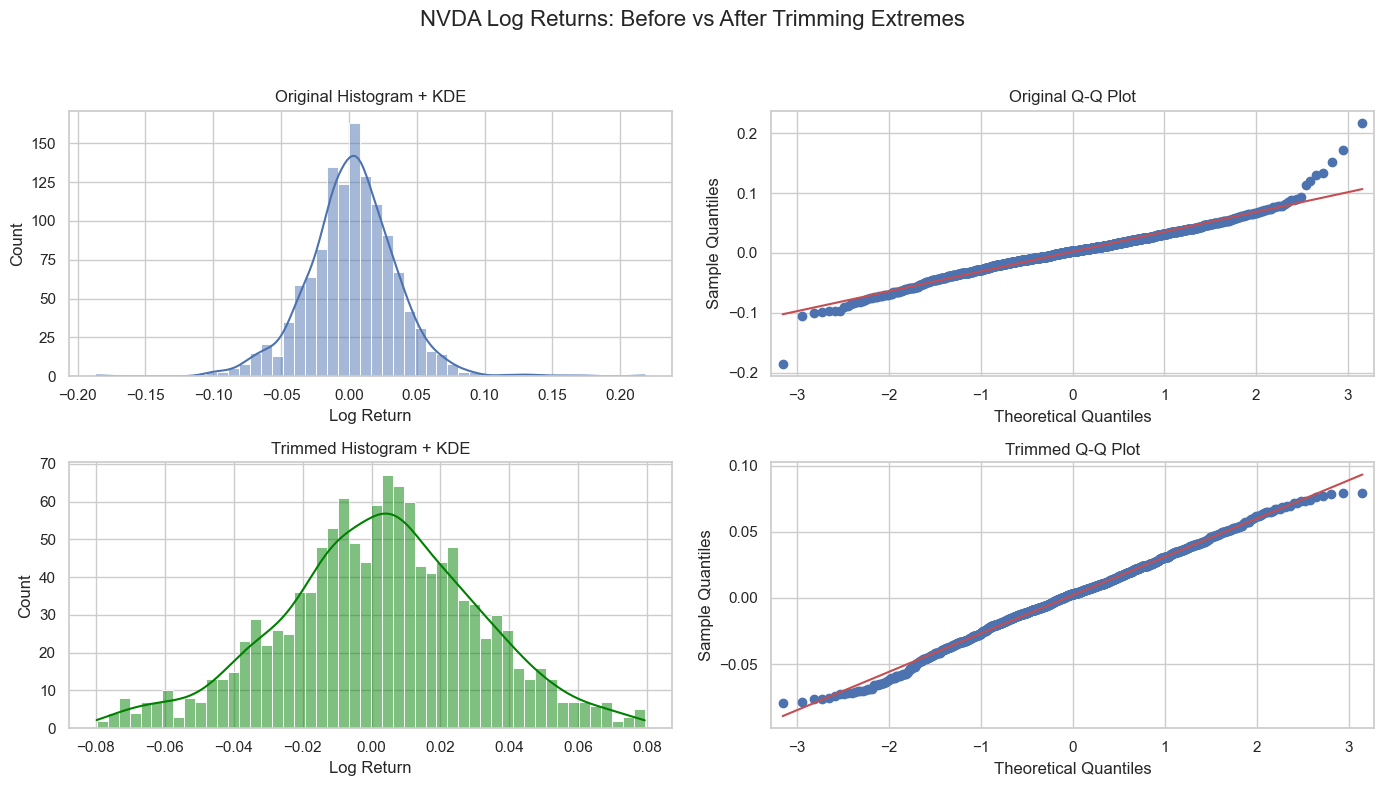

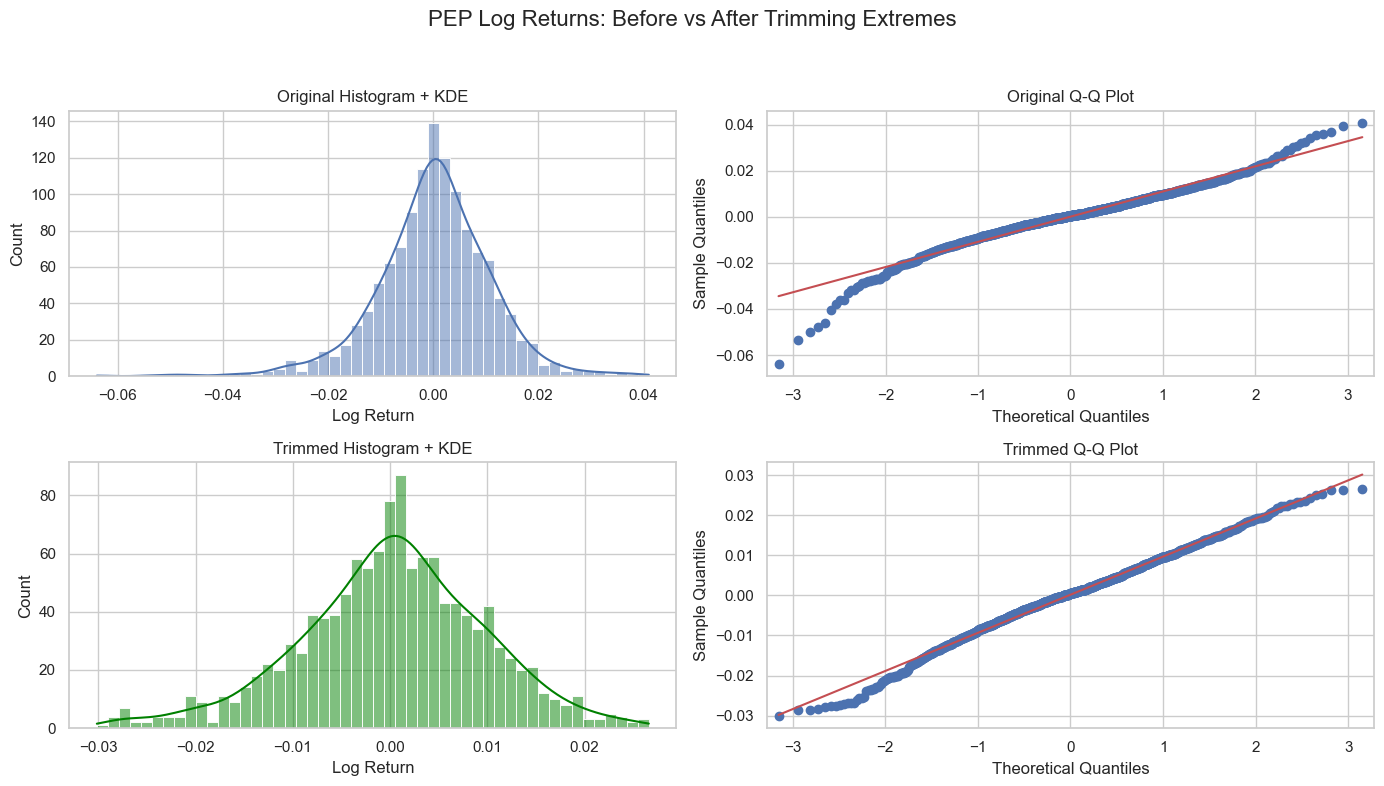

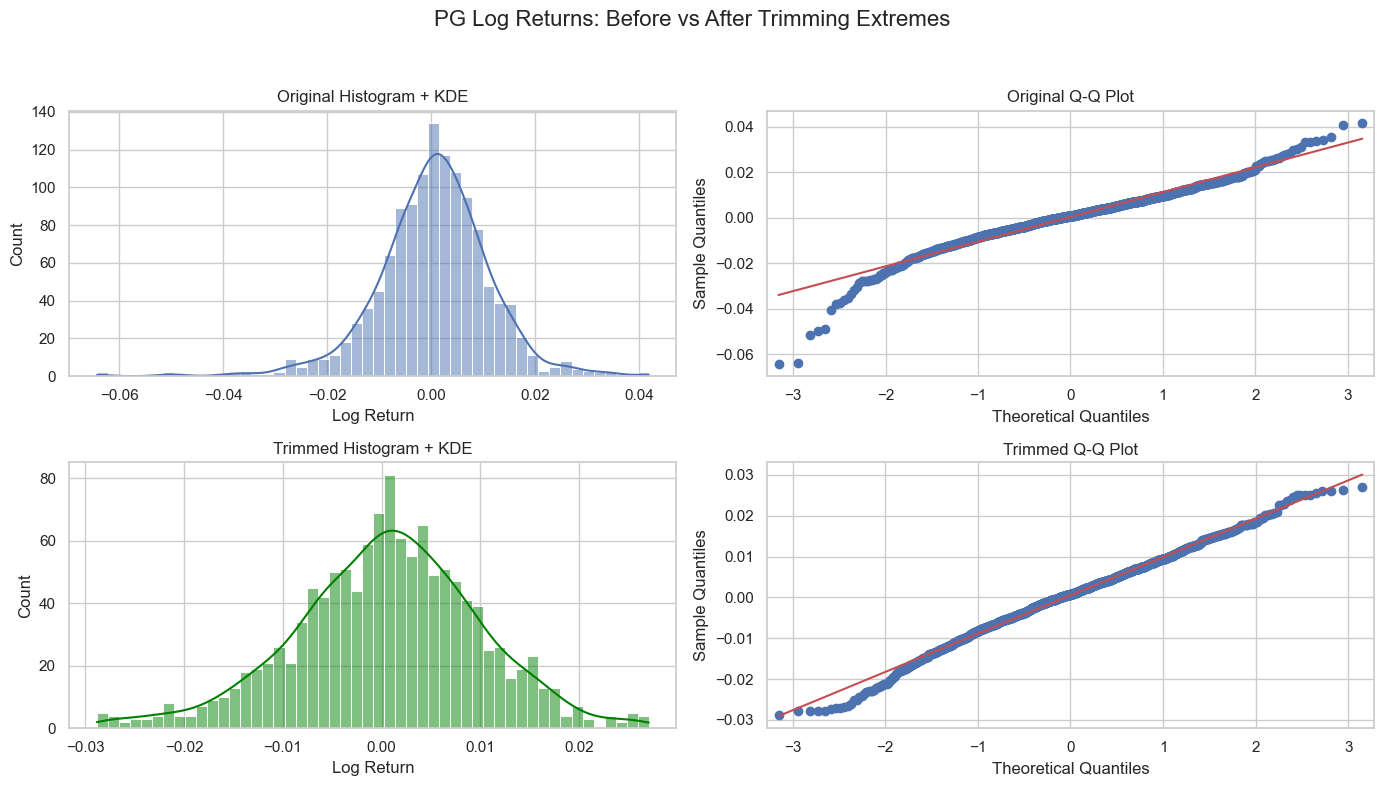

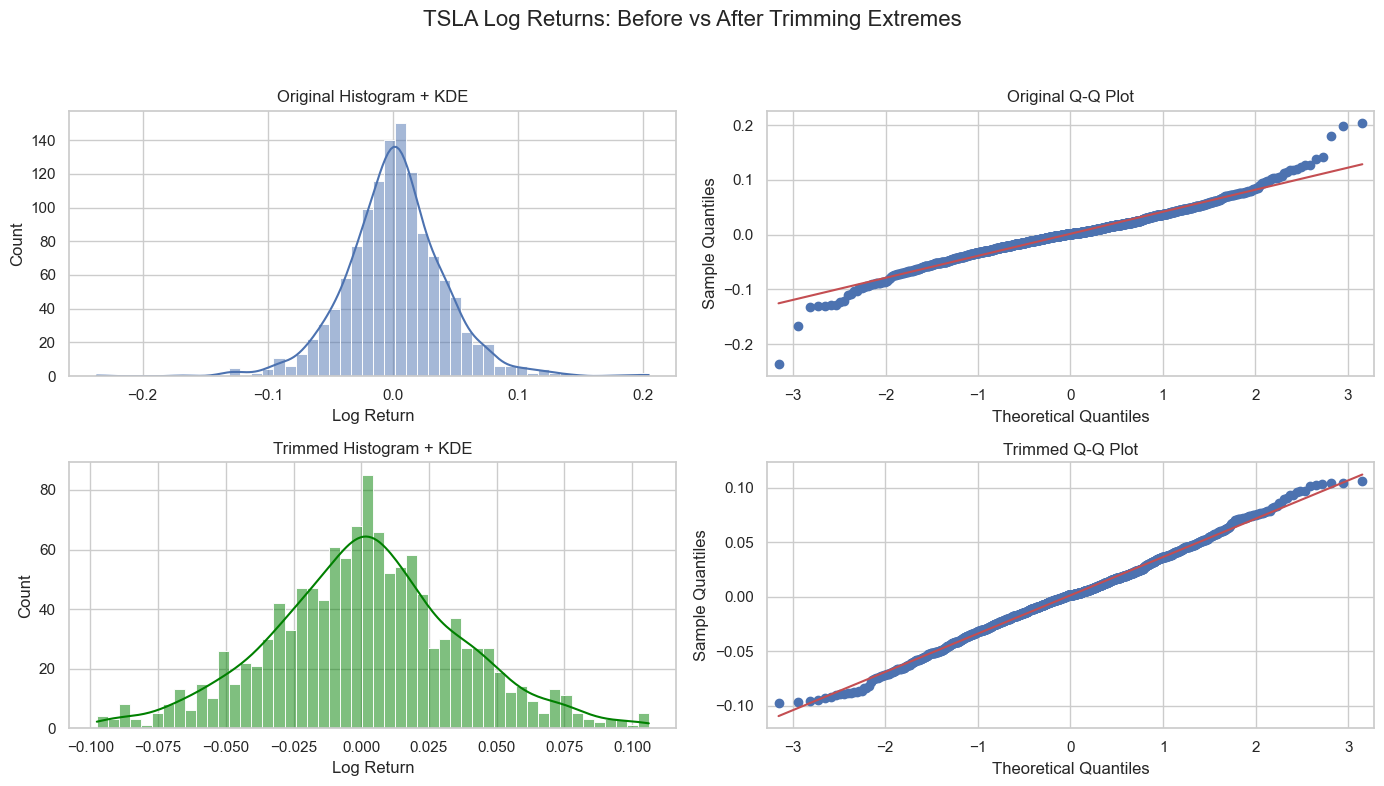

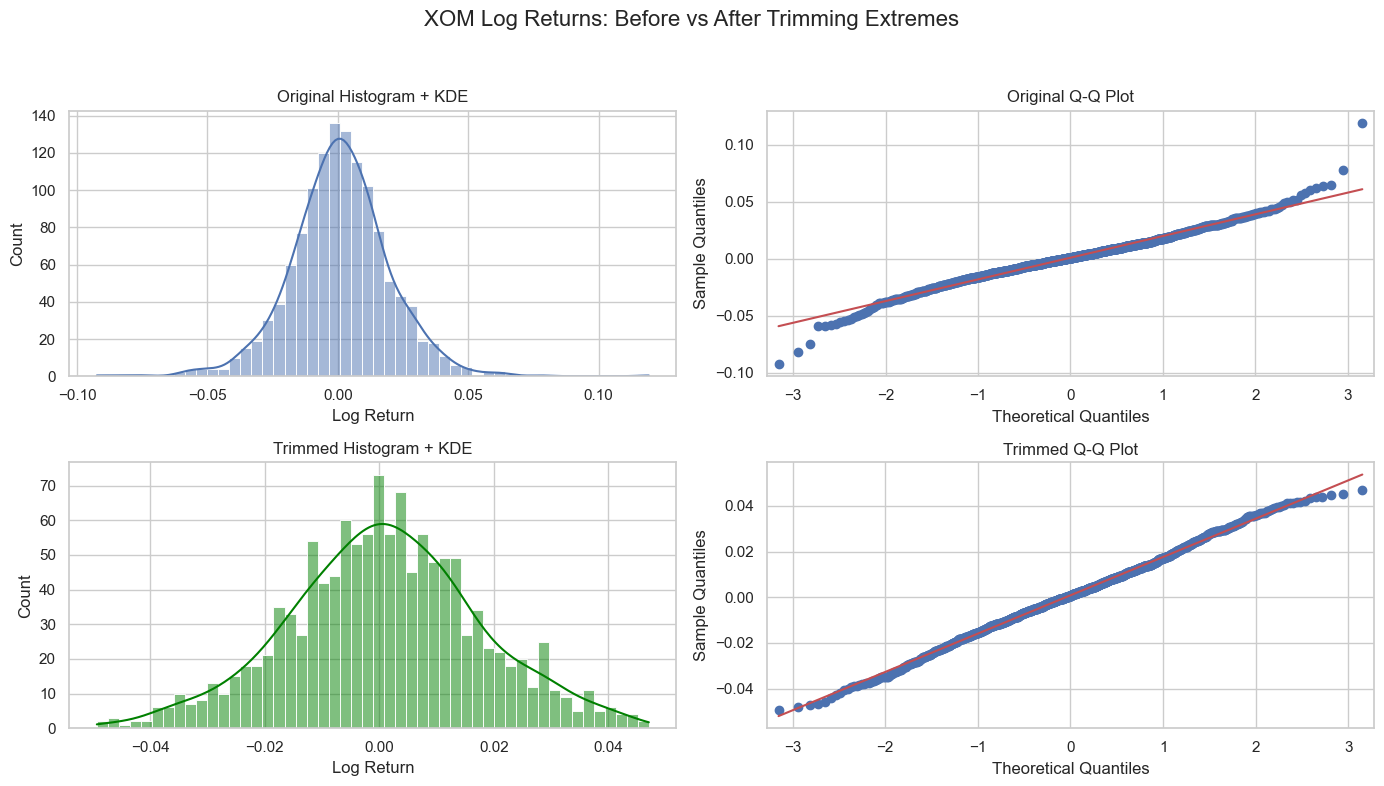

In [14]:
for stock in daily_log_returns.columns:
    original = daily_log_returns[stock].dropna()
    
    # Trim top and bottom 1%
    lower = original.quantile(0.01)
    upper = original.quantile(0.99)
    trimmed = original[(original >= lower) & (original <= upper)]

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f"{stock} Log Returns: Before vs After Trimming Extremes", fontsize=16)

    # Histogram + KDE (Original)
    sns.histplot(original, bins=50, kde=True, ax=axs[0, 0])
    axs[0, 0].set_title("Original Histogram + KDE")
    axs[0, 0].set_xlabel("Log Return")
    
    # Q-Q Plot (Original)
    sm.qqplot(original, line='s', ax=axs[0, 1])
    axs[0, 1].set_title("Original Q-Q Plot")

    # Histogram + KDE (Trimmed)
    sns.histplot(trimmed, bins=50, kde=True, color='green', ax=axs[1, 0])
    axs[1, 0].set_title("Trimmed Histogram + KDE")
    axs[1, 0].set_xlabel("Log Return")
    
    # Q-Q Plot (Trimmed)
    sm.qqplot(trimmed, line='s', ax=axs[1, 1])
    axs[1, 1].set_title("Trimmed Q-Q Plot")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

Now Trimming 3% from each end 

In [15]:
# Function to test normality after trimming extremes (3% from each end)
def test_normality_after_trimming(series, trim_percent=0.03):
    series = series.dropna()
    
    # Trim top and bottom trim_percent
    lower = series.quantile(trim_percent)
    upper = series.quantile(1 - trim_percent)
    trimmed = series[(series >= lower) & (series <= upper)]

    # Apply normality tests
    sw_t_p = shapiro(trimmed)[1]
    jb_t_p = jarque_bera(trimmed)[1]
    ad_t_result = anderson(trimmed)
    ad_t_pass = ad_t_result.statistic < ad_t_result.critical_values[2]  # 5% level

    return {
        'SW p (trimmed)': round(sw_t_p, 4),
        'JB p (trimmed)': round(jb_t_p, 4),
        'AD pass (trimmed)': ad_t_pass
    }

# Apply to all stocks in daily_log_returns
after_trim_results = {}

for stock in daily_log_returns.columns:
    after_trim_results[stock] = test_normality_after_trimming(daily_log_returns[stock])

# Convert to DataFrame
after_trim_normality_df = pd.DataFrame(after_trim_results).T

print("Trimmed Data Normality Test Results:")
print(after_trim_normality_df)


Trimmed Data Normality Test Results:
      SW p (trimmed) JB p (trimmed) AD pass (trimmed)
AAPL             0.0         0.0194             False
GOOGL         0.0002         0.0105             False
JNJ           0.0002         0.0166              True
KO            0.0007         0.0932              True
MSFT             0.0         0.0098             False
NVDA          0.0004         0.0121              True
PEP           0.0001         0.0107             False
PG            0.0001          0.005             False
TSLA          0.0003         0.0885              True
XOM           0.0006         0.0271              True


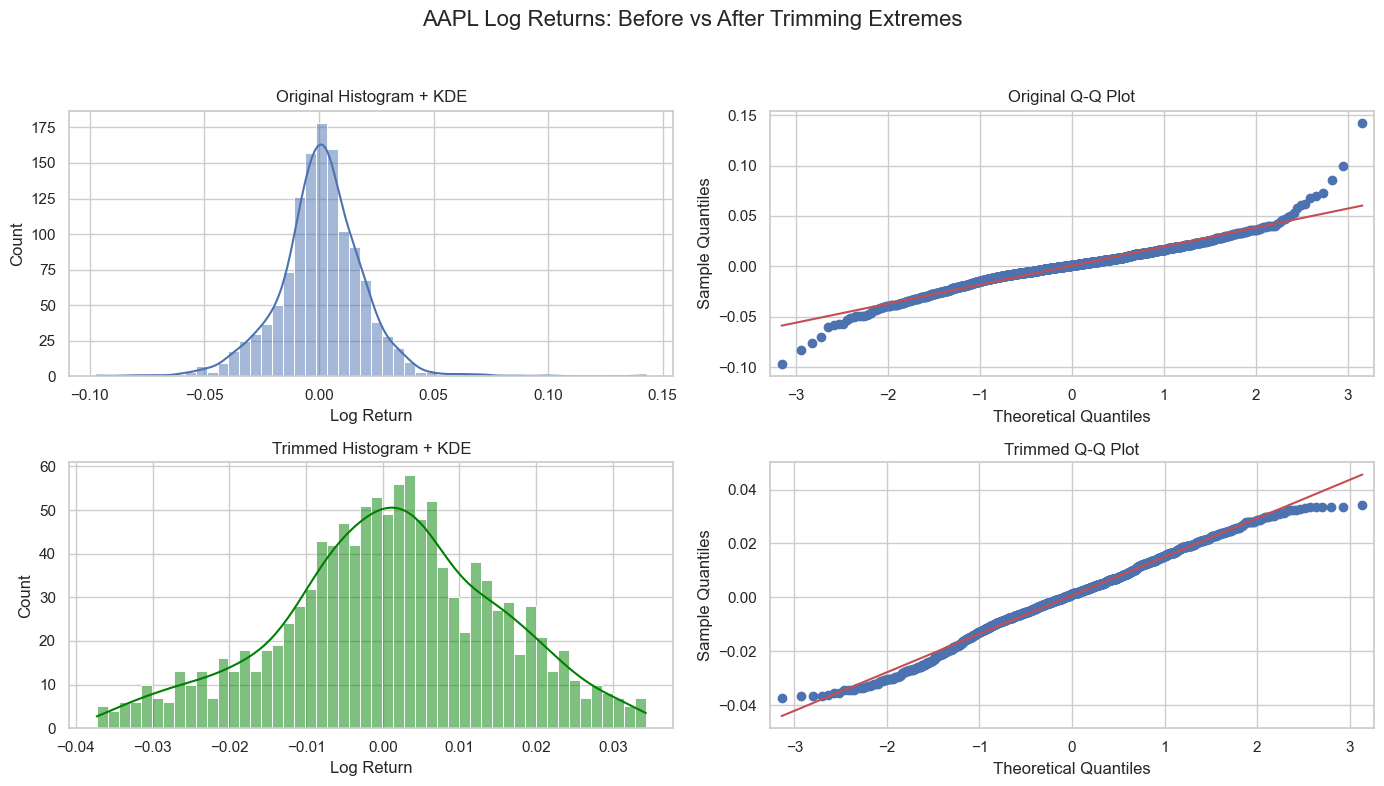

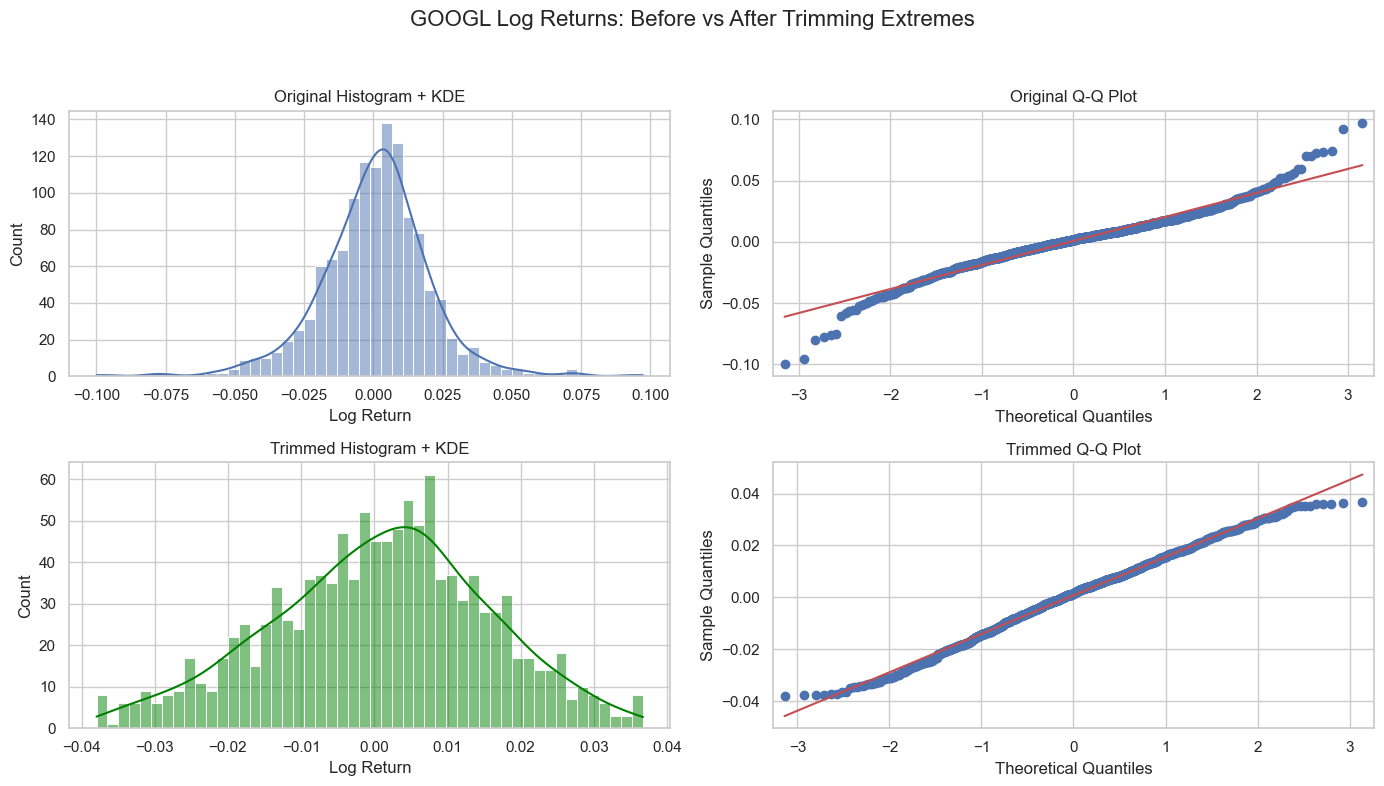

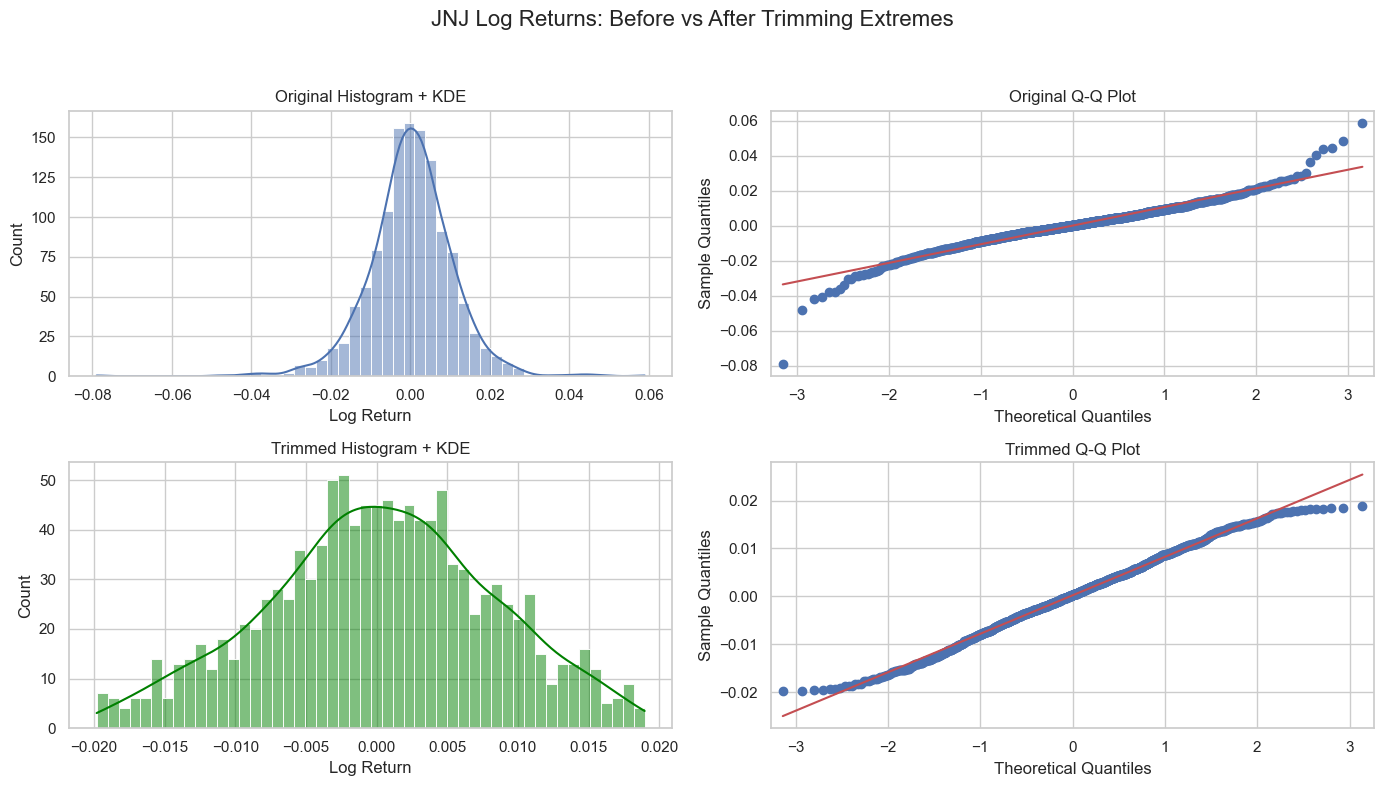

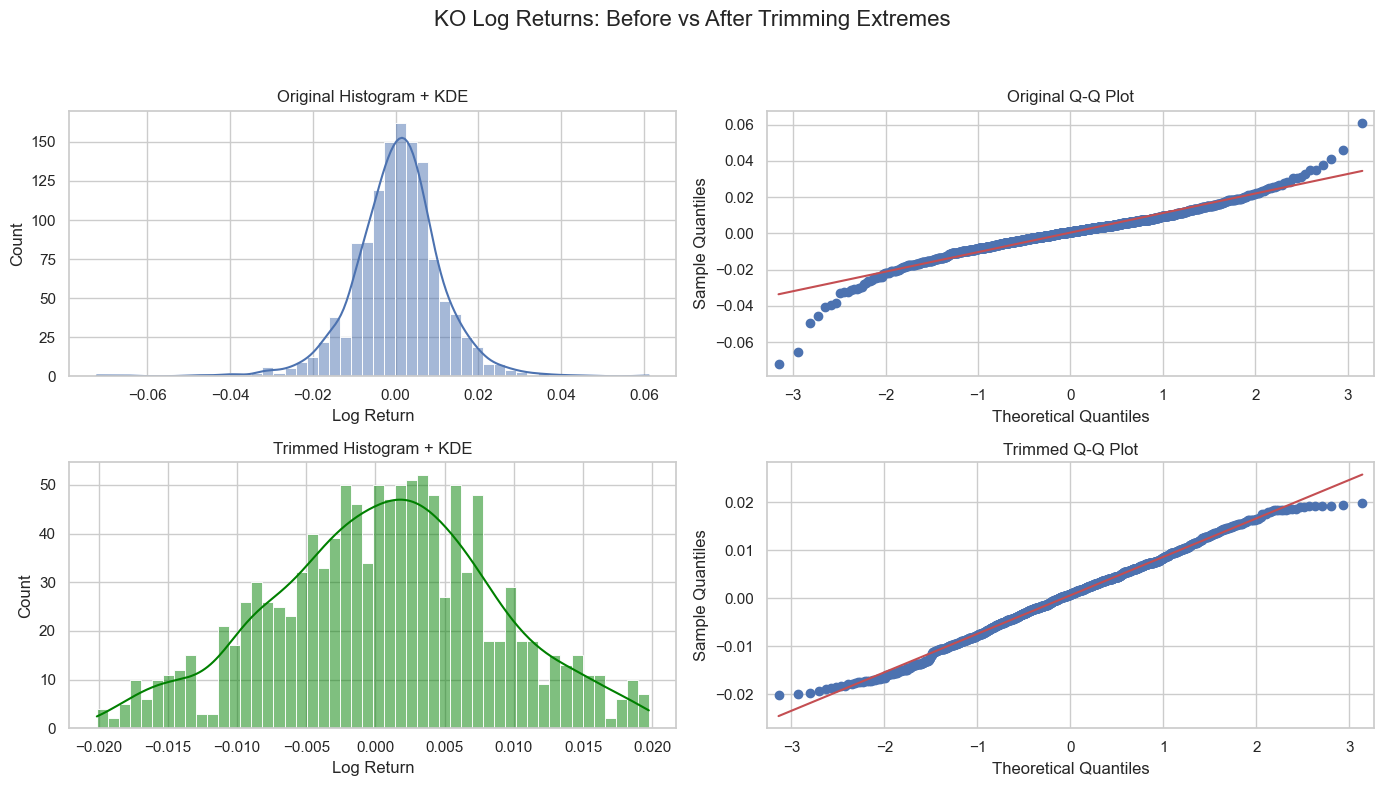

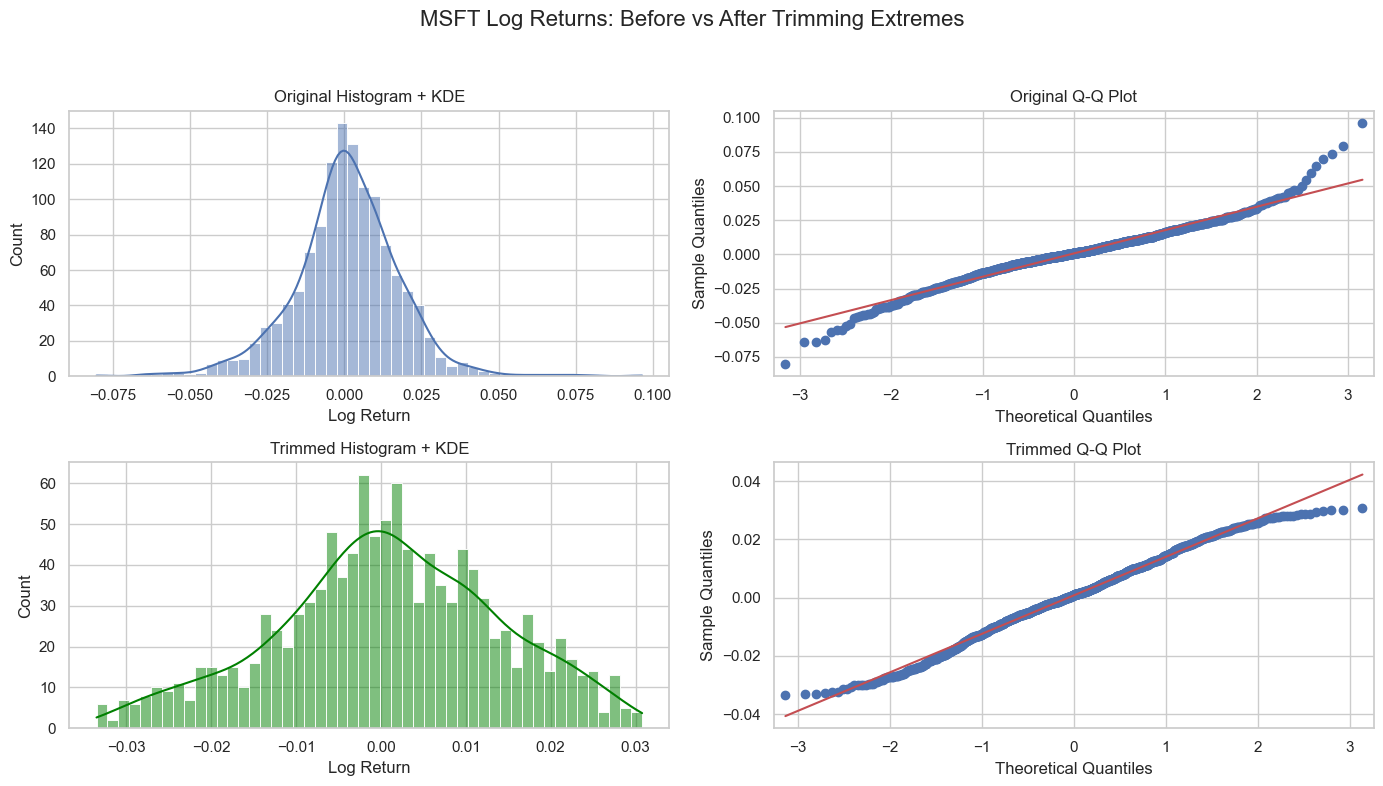

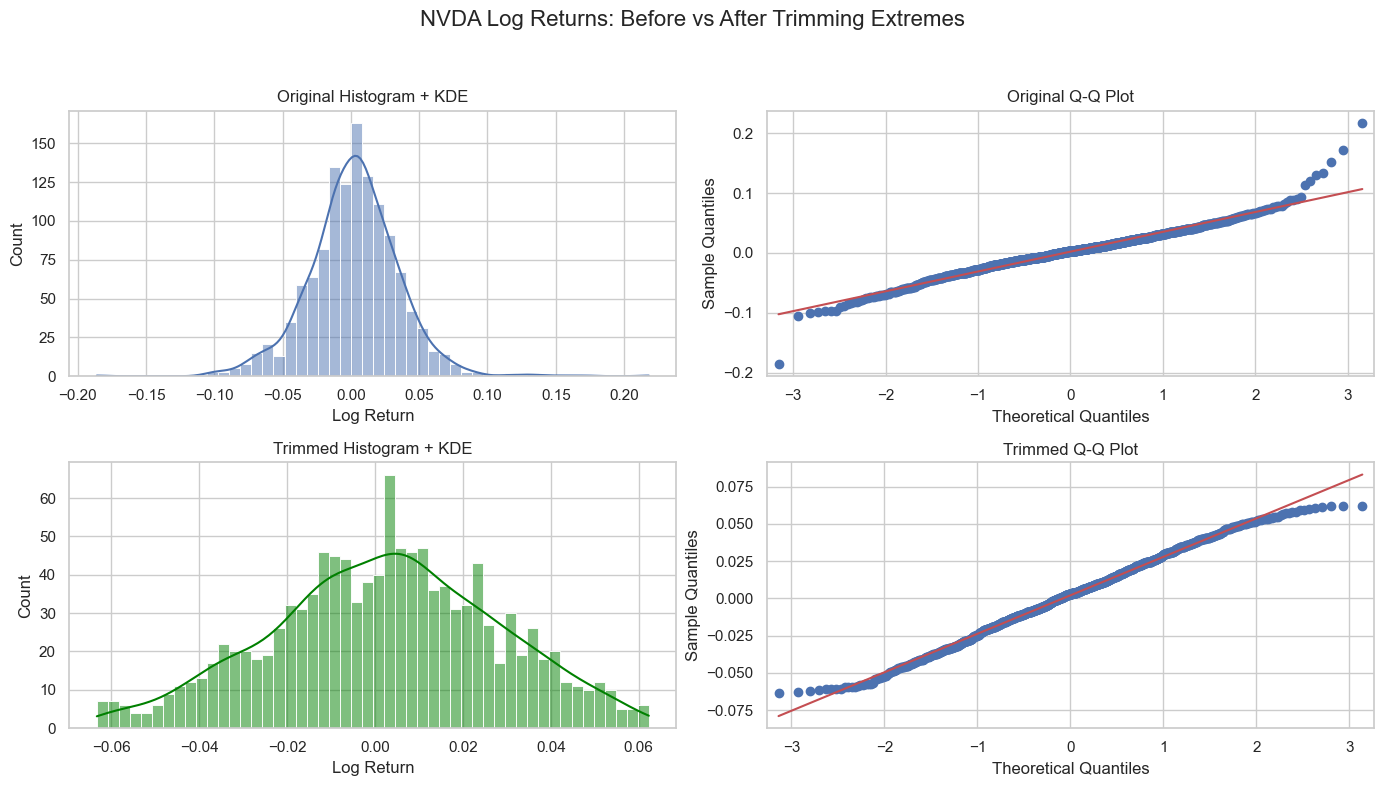

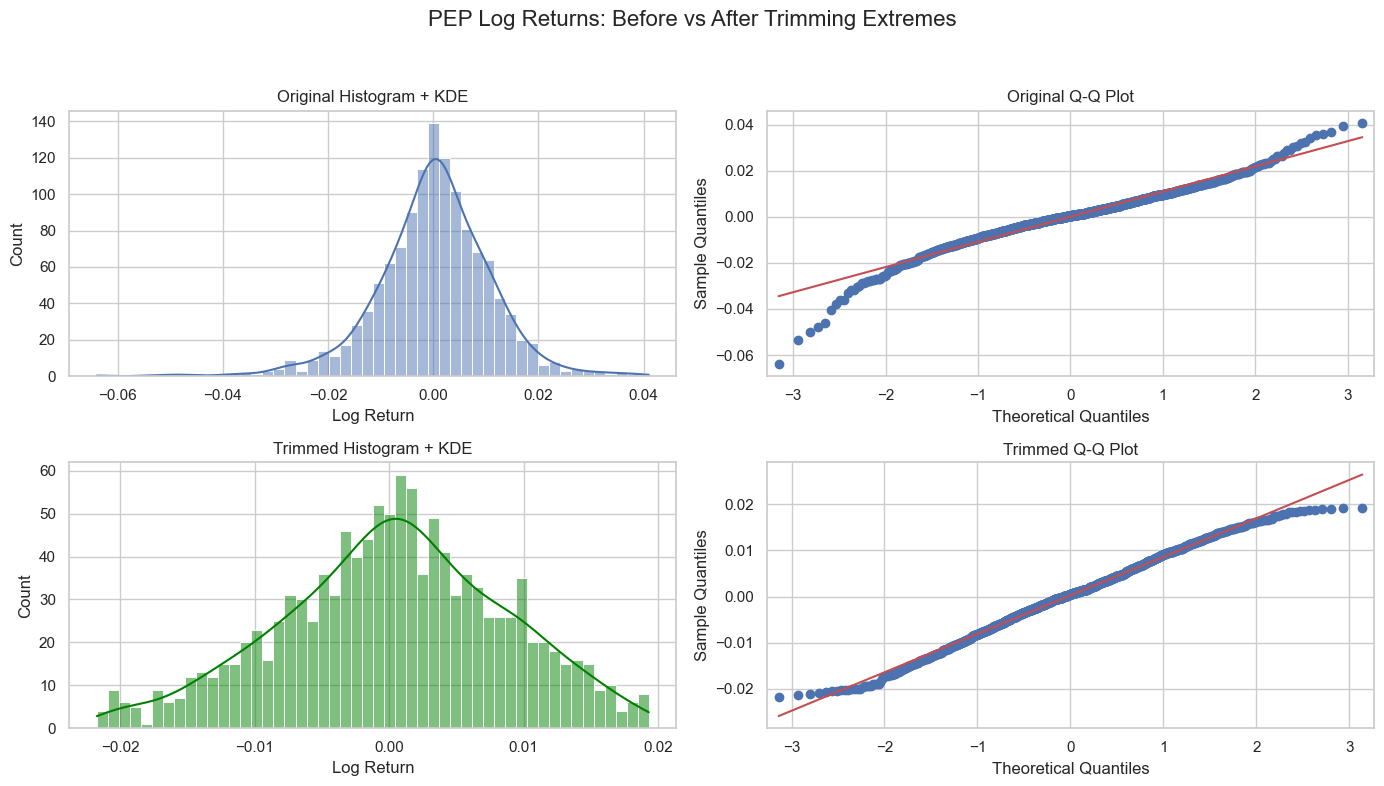

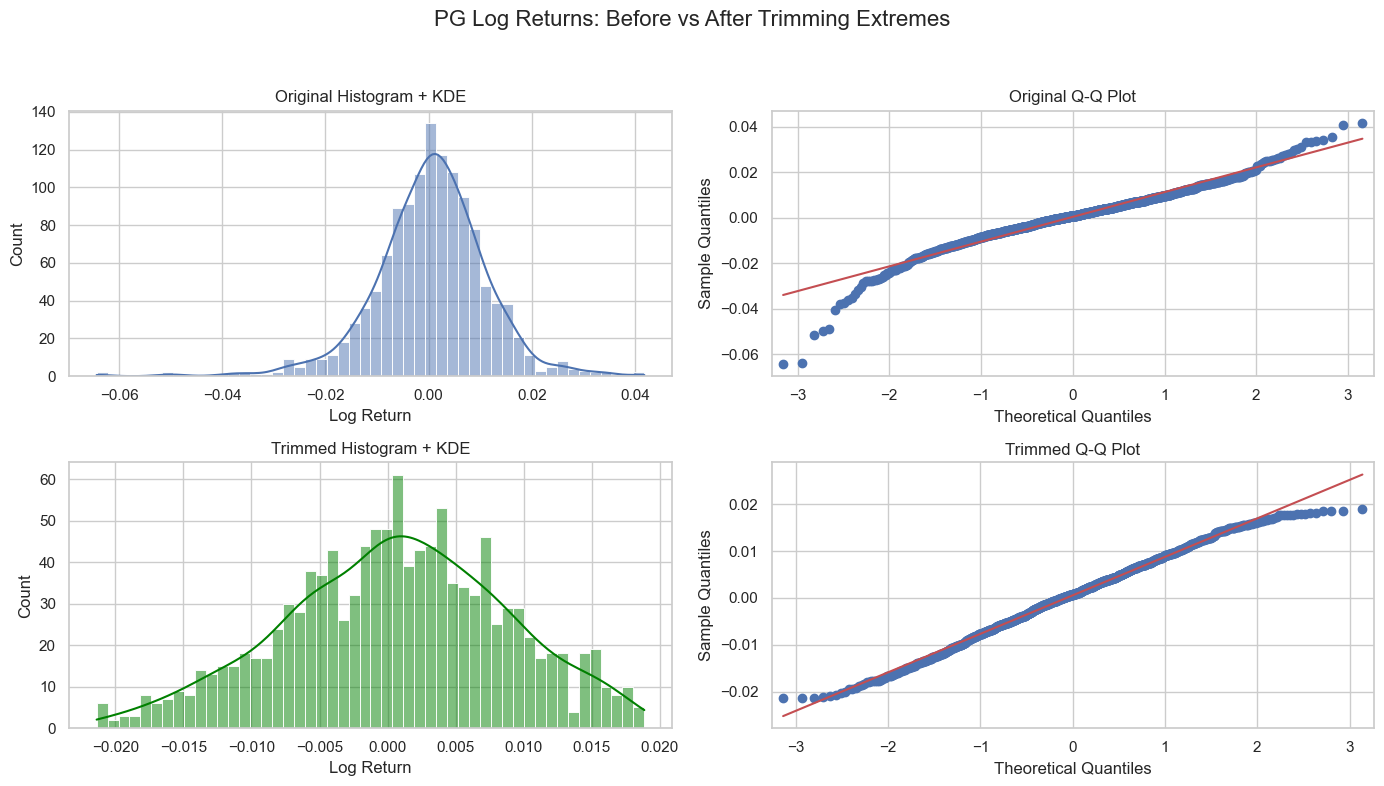

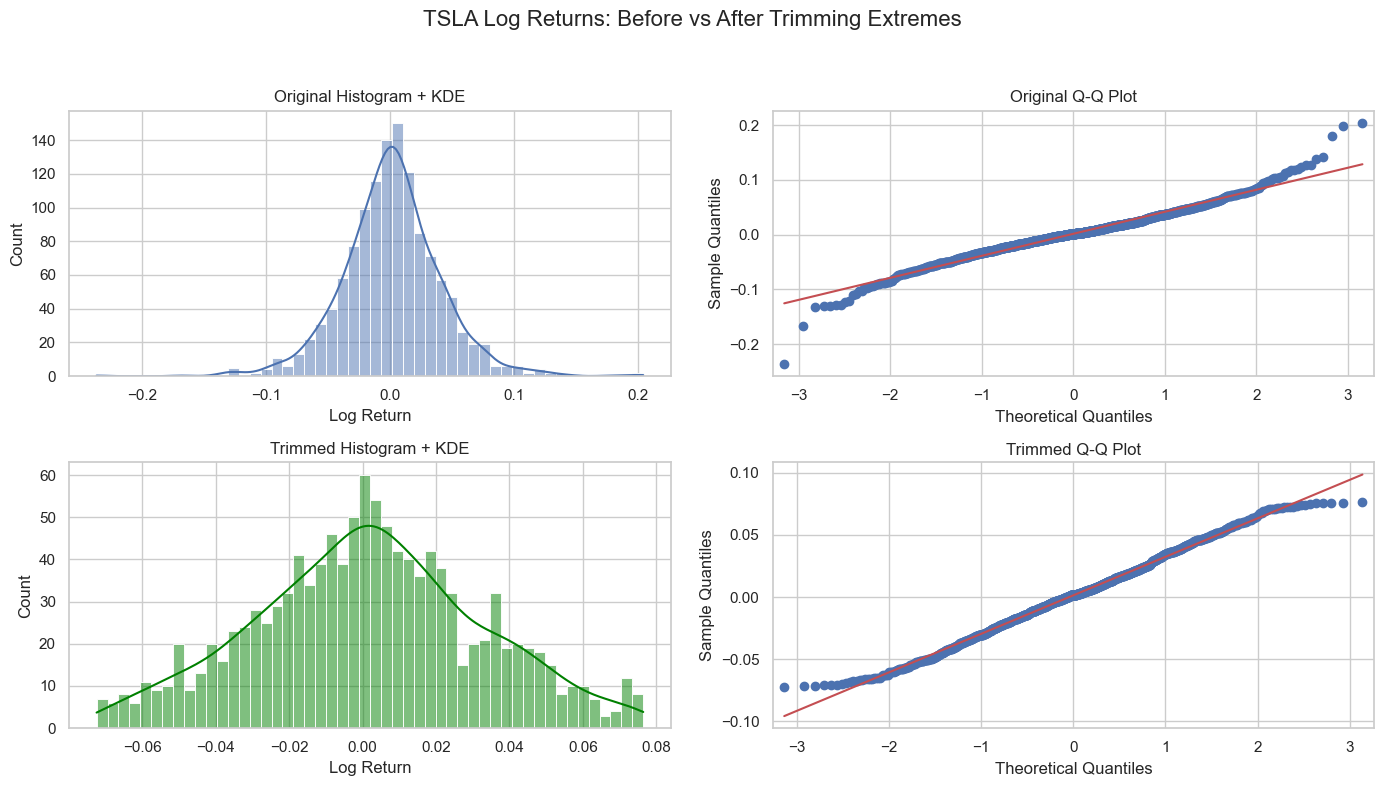

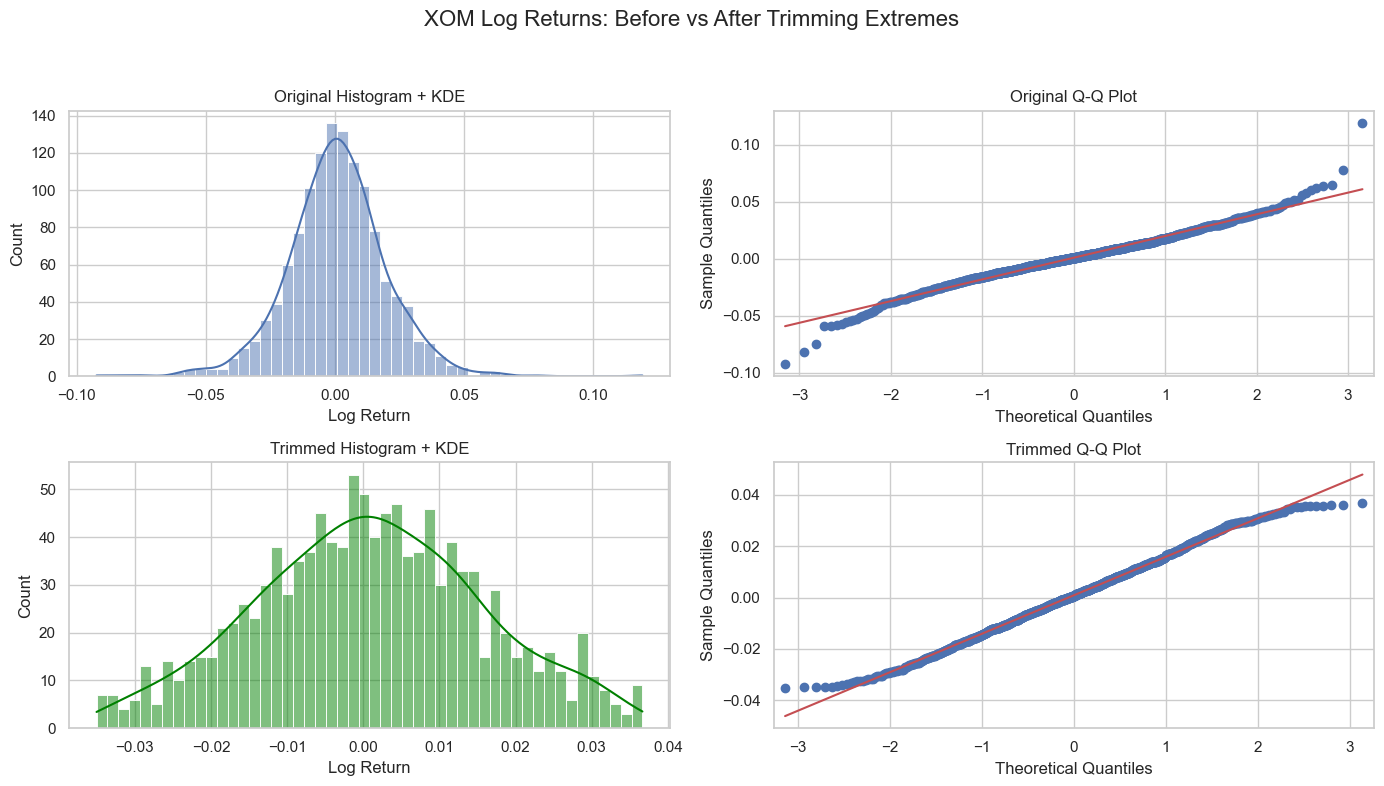

In [16]:
for stock in daily_log_returns.columns:
    original = daily_log_returns[stock].dropna()
    
    # Trim top and bottom 1%
    lower = original.quantile(0.03)
    upper = original.quantile(0.97)
    trimmed = original[(original >= lower) & (original <= upper)]

    # Plotting
    fig, axs = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle(f"{stock} Log Returns: Before vs After Trimming Extremes", fontsize=16)

    # Histogram + KDE (Original)
    sns.histplot(original, bins=50, kde=True, ax=axs[0, 0])
    axs[0, 0].set_title("Original Histogram + KDE")
    axs[0, 0].set_xlabel("Log Return")
    
    # Q-Q Plot (Original)
    sm.qqplot(original, line='s', ax=axs[0, 1])
    axs[0, 1].set_title("Original Q-Q Plot")

    # Histogram + KDE (Trimmed)
    sns.histplot(trimmed, bins=50, kde=True, color='green', ax=axs[1, 0])
    axs[1, 0].set_title("Trimmed Histogram + KDE")
    axs[1, 0].set_xlabel("Log Return")
    
    # Q-Q Plot (Trimmed)
    sm.qqplot(trimmed, line='s', ax=axs[1, 1])
    axs[1, 1].set_title("Trimmed Q-Q Plot")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

After increasing the trimming threshold (3%), 5 of the 10 stocks (including KO, TSLA, XOM) passed the Anderson-Darling test, indicating a stronger case for normality in their returns after removing more extreme values.

#### Now we will create a personalized portfolio of stocks with historical log return data that is normally distributed.


##### These 5 stocks passed the Anderson-Darling (AD) test after trimming: JNJ, KO, NVDA, TSLA, XOM 
##### We will construct a portfolio using these stocks having equal weights 
Constructing a portfolio from trimmed log return data (not raw), using the 5 stocks that showed normality after trimming, and then test the portfolio’s trimmed returns for normality.

In [17]:
#selected "normal" stocks
selected_stocks = ['JNJ', 'KO', 'NVDA', 'TSLA', 'XOM']

trim_percent = 0.03  # 3% trimming

#Trim each stock's returns
trimmed_returns = {}
for stock in selected_stocks:
    series = daily_log_returns[stock].dropna()
    lower = series.quantile(trim_percent)
    upper = series.quantile(1 - trim_percent)
    trimmed = series[(series >= lower) & (series <= upper)]
    trimmed_returns[stock] = trimmed
trimmed_df = pd.DataFrame(trimmed_returns).dropna()

#Create equal-weighted portfolio from trimmed returns
weights = np.array([1/len(selected_stocks)] * len(selected_stocks))
portfolio_trimmed_returns = trimmed_df.dot(weights)

#Run normality tests on the trimmed portfolio returns
def portfolio_normality_tests(series):
    series = series.dropna()
    sw_p = shapiro(series)[1]
    jb_p = jarque_bera(series)[1]
    ad_result = anderson(series)
    ad_pass = ad_result.statistic < ad_result.critical_values[2]
    return {
        "Shapiro-Wilk p": round(sw_p, 4),
        "Jarque-Bera p": round(jb_p, 4),
        "AD pass (5%)": ad_pass
    }

#results
portfolio_trimmed_normality = portfolio_normality_tests(portfolio_trimmed_returns)
print("Portfolio (trimmed 3%) Normality Test Results:")
print(portfolio_trimmed_normality)


Portfolio (trimmed 3%) Normality Test Results:
{'Shapiro-Wilk p': 0.3058, 'Jarque-Bera p': 0.9508, 'AD pass (5%)': True}


All three tests support the conclusion that our portfolio log returns are normally distributed — after constructing it from trimmed individual stock returns.